In [1]:
import gpflow
import numpy as np
import matplotlib
import pandas as pd
from multi_spectralmixture import MultiSpectralMixture as MOSM
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [2]:
dat=pd.read_csv('20180225_EG.csv', sep=',',header=0)
DATA = dat.values[1:].astype(np.float)
n_sensor = np.shape(DATA)[1]

C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\envs\mosm\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def build_XY(input_list, output_list):
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([I[:,None],X])
    
    Y = np.vstack(output_list)
#     Y = np.hstack([Y,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I


In [4]:
data_len = 150
X_list = []
Y_list = []
x = np.arange(data_len)[:,None].astype(float)
sensor = 5
for i in range(sensor):
    X_list.append(x)
    Y_list.append(DATA[:data_len,i+5][:,None])
    
X,Y,I = build_XY(X_list,Y_list)

In [7]:
#set data dimensions
INPUT_DIM = 1
N_OUTPUTS = sensor

number_of_components = 2
kern = MOSM(INPUT_DIM, N_OUTPUTS)
for i in range(number_of_components-1):
        kern += MOSM(INPUT_DIM, N_OUTPUTS)
        
# k1 = gpflow.kernels.Matern52(1, active_dims=[0])
# coreg = gpflow.kernels.Coregion(1, output_dim=sensor, rank=1, active_dims=[1])
# kern = k1 * coreg

In [8]:
# lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])

# now buld the GP model as normal
model = gpflow.models.GPR(X, Y, kern)
model.likelihood.variance = 0.5

# fit the covariance function parameters
gpflow.train.ScipyOptimizer().minimize(model, disp=True, maxiter=500)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3178.175125
  Number of iterations: 500
  Number of functions evaluations: 599


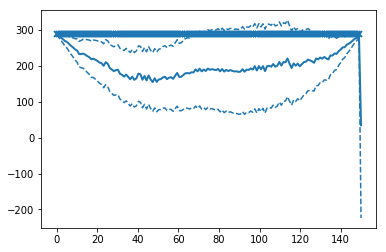

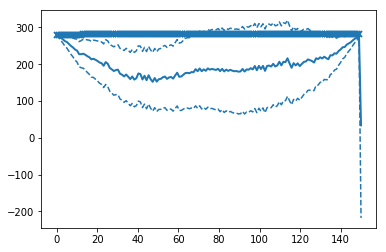

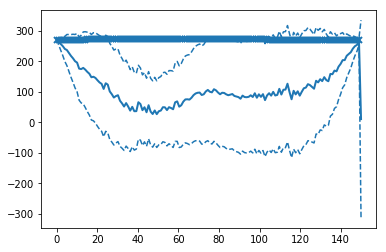

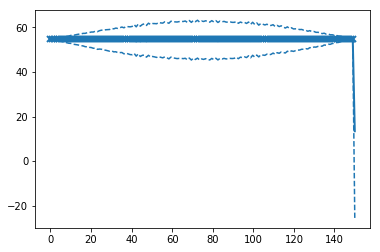

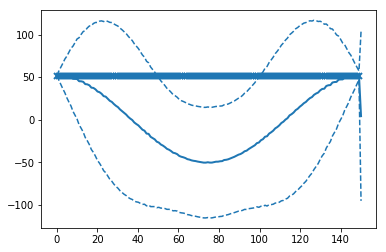

In [11]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)

def plot(m):
    xtest = np.linspace(0, 150, 150)[:,None]
    for i in range(sensor):
        line, = plt.plot(x, DATA[:data_len,i+5][:,None], 'x', mew=2)
        mu, var = m.predict_f(np.hstack((np.ones_like(xtest)*i,xtest)))
        plot_gp(xtest, mu[:,0][:,None], var[:,0][:,None], line.get_color())
        plt.show()

plot(model)

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1069.303531
  Number of iterations: 133
  Number of functions evaluations: 212


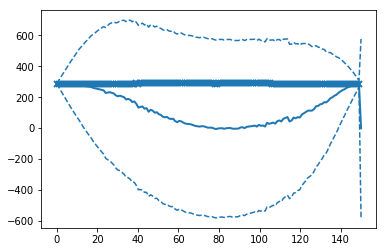

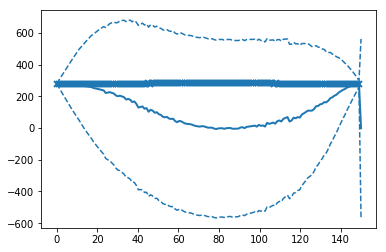

In [18]:
data_len = 150
X2_list = []
Y2_list = []
x = np.arange(data_len)[:,None].astype(float)
sensor = 2
for i in range(sensor):
    X2_list.append(x)
    Y2_list.append(DATA[:data_len,i+5][:,None])
    
X2,Y2,I = build_XY(X2_list,Y2_list)

# lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])

# now buld the GP model as normal
model2 = gpflow.models.GPR(X2, Y2, kern)
model2.likelihood.variance = 0.5

# fit the covariance function parameters
gpflow.train.ScipyOptimizer().minimize(model2)

plot(model2)

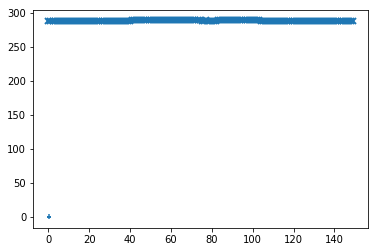

In [21]:
# a Coregionalization kernel. The base kernel is Matern, and acts on the first ([0]) data dimension.
# the 'Coregion' kernel indexes the outputs, and actos on the second ([1]) data dimension
X1 = np.arange(data_len)[:,None].astype(float)
X2 = np.arange(data_len)[:,None].astype(float)
Y1 = DATA[:data_len,5][:,None]
Y2 = DATA[:data_len,6][:,None]

k1 = gpflow.kernels.Matern32(1, active_dims=[0])
coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
kern = k1 * coreg

# build a variational model. This likelihood switches between Student-T noise with different variances:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])

# Augment the time data with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data to indicate which likeloihood we should use
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

# now buld the GP model as normal
m = gpflow.models.VGP(X_augmented, Y_augmented, kern=kern, likelihood=lik, num_latent=1)

def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)

def plot(m):
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

#     line, = plt.plot(X2, Y2, 'x', mew=2)
#     mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
#     plot_gp(xtest, mu, var, line.get_color())

plot(m)

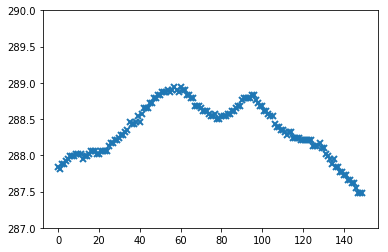

In [24]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)
    plt.ylim([287,290])

def plot(m):
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

#     line, = plt.plot(X2, Y2, 'x', mew=2)
#     mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
#     plot_gp(xtest, mu, var, line.get_color())

plot(m)

[[280.        ]
 [280.2020202 ]
 [280.4040404 ]
 [280.60606061]
 [280.80808081]
 [281.01010101]
 [281.21212121]
 [281.41414141]
 [281.61616162]
 [281.81818182]
 [282.02020202]
 [282.22222222]
 [282.42424242]
 [282.62626263]
 [282.82828283]
 [283.03030303]
 [283.23232323]
 [283.43434343]
 [283.63636364]
 [283.83838384]
 [284.04040404]
 [284.24242424]
 [284.44444444]
 [284.64646465]
 [284.84848485]
 [285.05050505]
 [285.25252525]
 [285.45454545]
 [285.65656566]
 [285.85858586]
 [286.06060606]
 [286.26262626]
 [286.46464646]
 [286.66666667]
 [286.86868687]
 [287.07070707]
 [287.27272727]
 [287.47474747]
 [287.67676768]
 [287.87878788]
 [288.08080808]
 [288.28282828]
 [288.48484848]
 [288.68686869]
 [288.88888889]
 [289.09090909]
 [289.29292929]
 [289.49494949]
 [289.6969697 ]
 [289.8989899 ]
 [290.1010101 ]
 [290.3030303 ]
 [290.50505051]
 [290.70707071]
 [290.90909091]
 [291.11111111]
 [291.31313131]
 [291.51515152]
 [291.71717172]
 [291.91919192]
 [292.12121212]
 [292.32323232]
 [292.52

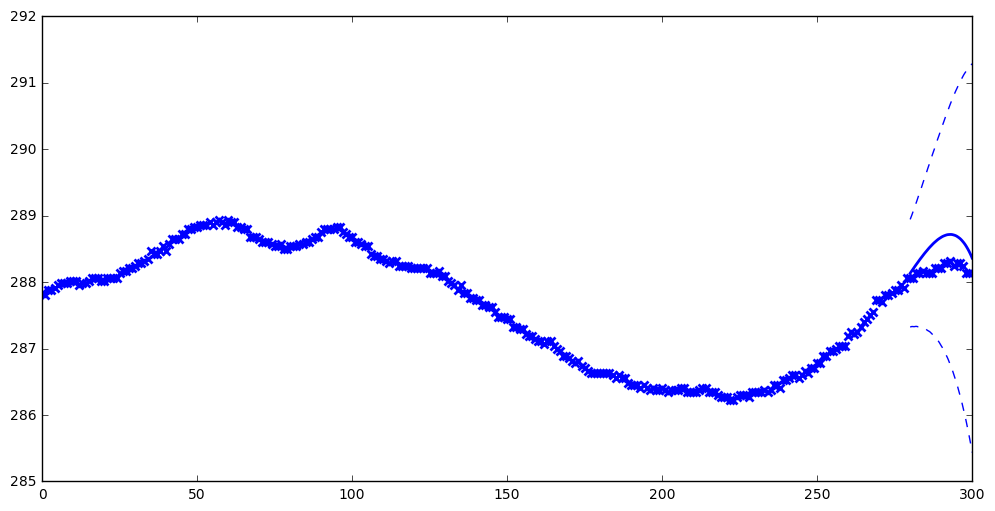

[[280.        ]
 [280.2020202 ]
 [280.4040404 ]
 [280.60606061]
 [280.80808081]
 [281.01010101]
 [281.21212121]
 [281.41414141]
 [281.61616162]
 [281.81818182]
 [282.02020202]
 [282.22222222]
 [282.42424242]
 [282.62626263]
 [282.82828283]
 [283.03030303]
 [283.23232323]
 [283.43434343]
 [283.63636364]
 [283.83838384]
 [284.04040404]
 [284.24242424]
 [284.44444444]
 [284.64646465]
 [284.84848485]
 [285.05050505]
 [285.25252525]
 [285.45454545]
 [285.65656566]
 [285.85858586]
 [286.06060606]
 [286.26262626]
 [286.46464646]
 [286.66666667]
 [286.86868687]
 [287.07070707]
 [287.27272727]
 [287.47474747]
 [287.67676768]
 [287.87878788]
 [288.08080808]
 [288.28282828]
 [288.48484848]
 [288.68686869]
 [288.88888889]
 [289.09090909]
 [289.29292929]
 [289.49494949]
 [289.6969697 ]
 [289.8989899 ]
 [290.1010101 ]
 [290.3030303 ]
 [290.50505051]
 [290.70707071]
 [290.90909091]
 [291.11111111]
 [291.31313131]
 [291.51515152]
 [291.71717172]
 [291.91919192]
 [292.12121212]
 [292.32323232]
 [292.52

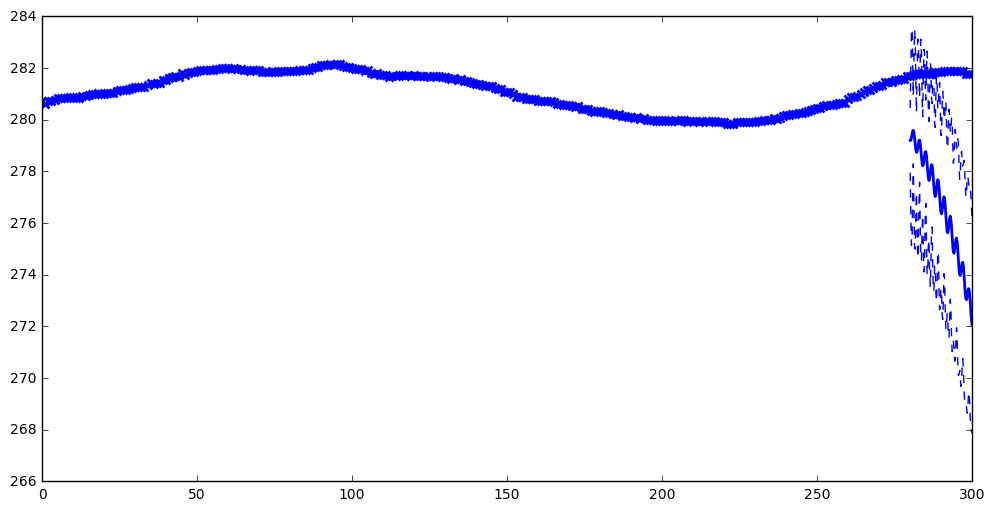

[[280.        ]
 [280.2020202 ]
 [280.4040404 ]
 [280.60606061]
 [280.80808081]
 [281.01010101]
 [281.21212121]
 [281.41414141]
 [281.61616162]
 [281.81818182]
 [282.02020202]
 [282.22222222]
 [282.42424242]
 [282.62626263]
 [282.82828283]
 [283.03030303]
 [283.23232323]
 [283.43434343]
 [283.63636364]
 [283.83838384]
 [284.04040404]
 [284.24242424]
 [284.44444444]
 [284.64646465]
 [284.84848485]
 [285.05050505]
 [285.25252525]
 [285.45454545]
 [285.65656566]
 [285.85858586]
 [286.06060606]
 [286.26262626]
 [286.46464646]
 [286.66666667]
 [286.86868687]
 [287.07070707]
 [287.27272727]
 [287.47474747]
 [287.67676768]
 [287.87878788]
 [288.08080808]
 [288.28282828]
 [288.48484848]
 [288.68686869]
 [288.88888889]
 [289.09090909]
 [289.29292929]
 [289.49494949]
 [289.6969697 ]
 [289.8989899 ]
 [290.1010101 ]
 [290.3030303 ]
 [290.50505051]
 [290.70707071]
 [290.90909091]
 [291.11111111]
 [291.31313131]
 [291.51515152]
 [291.71717172]
 [291.91919192]
 [292.12121212]
 [292.32323232]
 [292.52

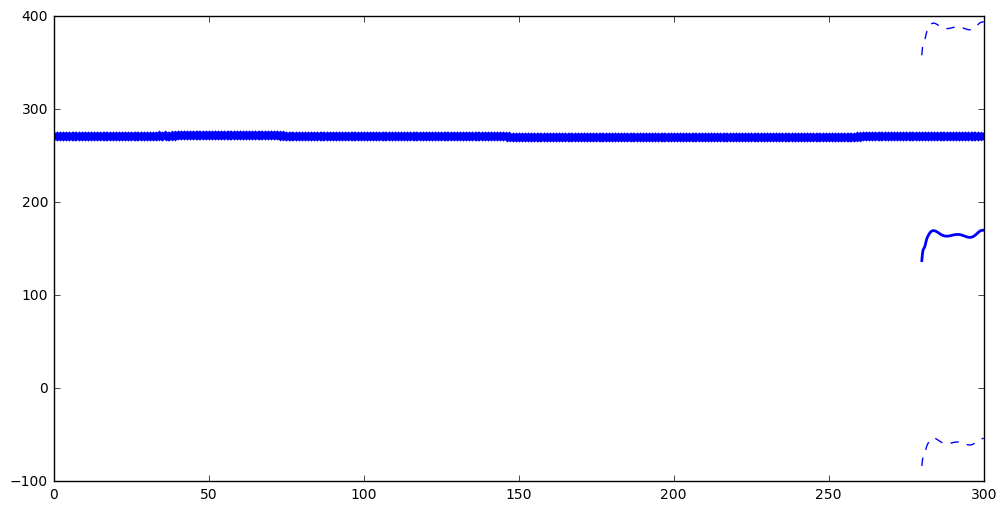

[[280.        ]
 [280.2020202 ]
 [280.4040404 ]
 [280.60606061]
 [280.80808081]
 [281.01010101]
 [281.21212121]
 [281.41414141]
 [281.61616162]
 [281.81818182]
 [282.02020202]
 [282.22222222]
 [282.42424242]
 [282.62626263]
 [282.82828283]
 [283.03030303]
 [283.23232323]
 [283.43434343]
 [283.63636364]
 [283.83838384]
 [284.04040404]
 [284.24242424]
 [284.44444444]
 [284.64646465]
 [284.84848485]
 [285.05050505]
 [285.25252525]
 [285.45454545]
 [285.65656566]
 [285.85858586]
 [286.06060606]
 [286.26262626]
 [286.46464646]
 [286.66666667]
 [286.86868687]
 [287.07070707]
 [287.27272727]
 [287.47474747]
 [287.67676768]
 [287.87878788]
 [288.08080808]
 [288.28282828]
 [288.48484848]
 [288.68686869]
 [288.88888889]
 [289.09090909]
 [289.29292929]
 [289.49494949]
 [289.6969697 ]
 [289.8989899 ]
 [290.1010101 ]
 [290.3030303 ]
 [290.50505051]
 [290.70707071]
 [290.90909091]
 [291.11111111]
 [291.31313131]
 [291.51515152]
 [291.71717172]
 [291.91919192]
 [292.12121212]
 [292.32323232]
 [292.52

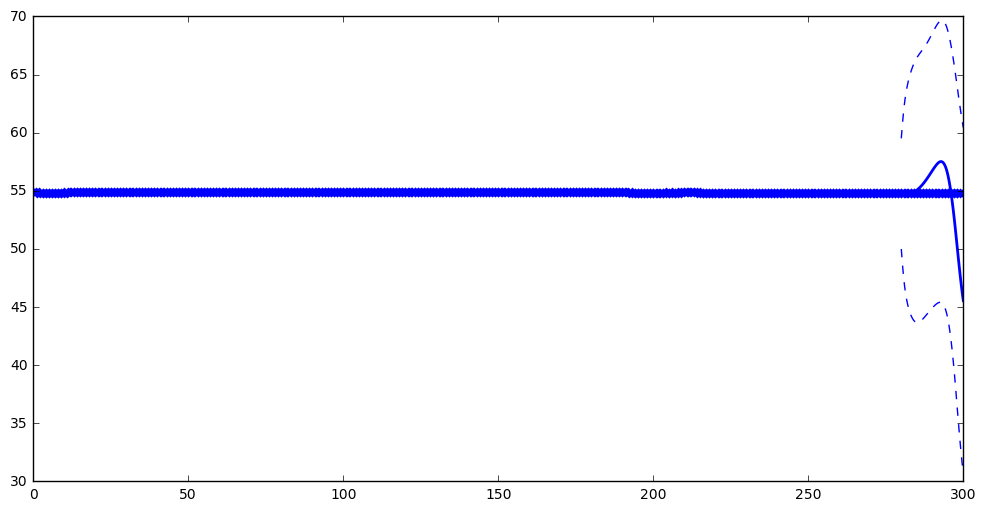

[[280.        ]
 [280.2020202 ]
 [280.4040404 ]
 [280.60606061]
 [280.80808081]
 [281.01010101]
 [281.21212121]
 [281.41414141]
 [281.61616162]
 [281.81818182]
 [282.02020202]
 [282.22222222]
 [282.42424242]
 [282.62626263]
 [282.82828283]
 [283.03030303]
 [283.23232323]
 [283.43434343]
 [283.63636364]
 [283.83838384]
 [284.04040404]
 [284.24242424]
 [284.44444444]
 [284.64646465]
 [284.84848485]
 [285.05050505]
 [285.25252525]
 [285.45454545]
 [285.65656566]
 [285.85858586]
 [286.06060606]
 [286.26262626]
 [286.46464646]
 [286.66666667]
 [286.86868687]
 [287.07070707]
 [287.27272727]
 [287.47474747]
 [287.67676768]
 [287.87878788]
 [288.08080808]
 [288.28282828]
 [288.48484848]
 [288.68686869]
 [288.88888889]
 [289.09090909]
 [289.29292929]
 [289.49494949]
 [289.6969697 ]
 [289.8989899 ]
 [290.1010101 ]
 [290.3030303 ]
 [290.50505051]
 [290.70707071]
 [290.90909091]
 [291.11111111]
 [291.31313131]
 [291.51515152]
 [291.71717172]
 [291.91919192]
 [292.12121212]
 [292.32323232]
 [292.52

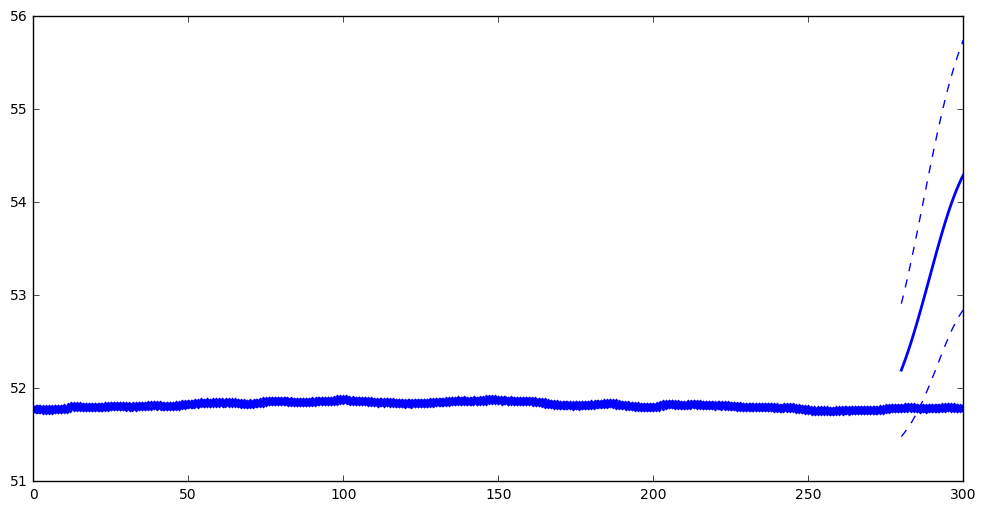

In [29]:
start = 0
test_data = 300
x = np.arange(test_data)[:,None].astype(float)+start

for j in range(sensor):
    X_test = []
    Y_test = []

    for i in range(sensor):
        if i == j:
            X_test.append(x[:280])
            Y_test.append(DATA[start:start+test_data-20,i+5][:,None])
        else:
            X_test.append(x)
            Y_test.append(DATA[start:start+test_data,i+5][:,None])

    Xt,Yt,It = build_XY(X_test,Y_test)

    m_test = gpflow.models.GPR(Xt,Yt,model.kern)

    xtest = np.linspace(start+280, start+test_data, 100)[:,None]

    line, = plt.plot(x, DATA[start:start+test_data,j+5][:,None], 'x', mew=2)
    print(xtest)
    mu, var = m_test.predict_f(np.hstack((np.ones_like(xtest)*j,xtest)))
    plot_gp(xtest, mu[:,0][:,None], var[:,0][:,None], line.get_color())
    plt.show()

In [22]:
np.hstack((np.ones_like(xtest)*j,xtest))

array([[  0.        , 500.        ],
       [  0.        , 501.50753769],
       [  0.        , 503.01507538],
       [  0.        , 504.52261307],
       [  0.        , 506.03015075],
       [  0.        , 507.53768844],
       [  0.        , 509.04522613],
       [  0.        , 510.55276382],
       [  0.        , 512.06030151],
       [  0.        , 513.5678392 ],
       [  0.        , 515.07537688],
       [  0.        , 516.58291457],
       [  0.        , 518.09045226],
       [  0.        , 519.59798995],
       [  0.        , 521.10552764],
       [  0.        , 522.61306533],
       [  0.        , 524.12060302],
       [  0.        , 525.6281407 ],
       [  0.        , 527.13567839],
       [  0.        , 528.64321608],
       [  0.        , 530.15075377],
       [  0.        , 531.65829146],
       [  0.        , 533.16582915],
       [  0.        , 534.67336683],
       [  0.        , 536.18090452],
       [  0.        , 537.68844221],
       [  0.        , 539.1959799 ],
 

In [25]:
model.kern